#VAE Implementation with Temporal Dependency incprporation in latent space

Problem Statement:
Automatic story generation (ASG) involves the ability to generate coherent and engaging stories and has many potential applications, from creative writing to chatbots and virtual assistants. In recent years, it has gained a lot of popularity and is an active research area. 

Dataset: For this project, we will use the WritingPrompts dataset, which was released by Facebook Research. This contains over 300,000 short stories. We will use a part of this dataset, owing to the limited computing resources available, and split the dataset into training, validation, and test sets for training and evaluating our models.



Idea:

1.   We first load the WritingPrompts dataset 
2.   Preprocess the dataset
3.   Define the model architecture
4.   Train the Model
5.   Test the model
6.   Plot the graphs - accuracy and other metrics
8.   Compare the performance blue score, perplexity
9.   Identify the limitations of TD-VAE


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.1 MB/s eta 0:00:00


In [ ]:
# import necessary packages
import os
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn
import torchtext
from torchtext.utils import download_from_url
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load the Dataset and Preprocess

For this project, we will use the WritingPrompts dataset, which was released by Facebook Research. This contains over 300,000 short stories. We will use a part of this dataset, owing to the limited computing resources available, and split the dataset into training, validation, and test sets for training and evaluating our models.

From https://github.com/facebookresearch/fairseq/tree/main/examples/stories 



In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/DL Final Project/Pickles-first10k/"

# Load the tokenized data from a file
with open(data_dir+'train_src_tokenized.pickle', 'rb') as f:
    train_src_tokenized = pickle.load(f)

with open(data_dir+'train_tgt_tokenized.pickle', 'rb') as f:
    train_tgt_tokenized = pickle.load(f)

with open(data_dir+'val_src_tokenized.pickle', 'rb') as f:
    val_src_tokenized = pickle.load(f)

with open(data_dir+'val_tgt_tokenized.pickle', 'rb') as f:
    val_tgt_tokenized = pickle.load(f)

with open(data_dir+'test_src_tokenized.pickle', 'rb') as f:
    test_src_tokenized = pickle.load(f)

with open(data_dir+'test_tgt_tokenized.pickle', 'rb') as f:
    test_tgt_tokenized = pickle.load(f)

Tokenize the data using BertTokenizer

In [ ]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_src_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in train_src_tokenized]
train_tgt_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in train_tgt_tokenized]
val_src_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in val_src_tokenized]
val_tgt_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in val_tgt_tokenized]
test_src_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in test_src_tokenized]
test_tgt_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in test_tgt_tokenized]


Convert to tensors and pad them

In [ ]:
train_src_tensor = [torch.tensor(seq) for seq in train_src_tokenized_bert]
train_tgt_tensor = [torch.tensor(seq) for seq in train_tgt_tokenized_bert]
val_src_tensor = [torch.tensor(seq) for seq in val_src_tokenized_bert]
val_tgt_tensor = [torch.tensor(seq) for seq in val_tgt_tokenized_bert]
test_src_tensor = [torch.tensor(seq) for seq in test_src_tokenized_bert]
test_tgt_tensor = [torch.tensor(seq) for seq in test_tgt_tokenized_bert]

train_src_padded = pad_sequence(train_src_tensor, batch_first=True)
train_tgt_padded = pad_sequence(train_tgt_tensor, batch_first=True)
val_src_padded = pad_sequence(val_src_tensor, batch_first=True)
val_tgt_padded = pad_sequence(val_tgt_tensor, batch_first=True)
test_src_padded = pad_sequence(test_src_tensor, batch_first=True)
test_tgt_padded = pad_sequence(test_tgt_tensor, batch_first=True)


class TranslationDataset(Dataset):
    def __init__(self, src_tensor, tgt_tensor):
        self.src_tensor = src_tensor
        self.tgt_tensor = tgt_tensor

    def __len__(self):
        return len(self.src_tensor)

    def __getitem__(self, idx):
        return self.src_tensor[idx], self.tgt_tensor[idx]

train_dataset = TranslationDataset(train_src_padded, train_tgt_padded)
val_dataset = TranslationDataset(val_src_padded, val_tgt_padded)
test_dataset = TranslationDataset(test_src_padded, test_tgt_padded)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
print(f"Tokenized length train => Source: {len(train_src_tokenized)}, Target: {len(train_tgt_tokenized)}")

Tokenized length train => Source: 10001, Target: 10001


# Define the model

Parts of the code are inspired by https://github.com/ankitkv/TD-VAE/blob/master/models/tdvae/tdvae.py and https://github.com/xqding/TD-VAE/blob/master/script/model.py 





In [ ]:
class TDVAE(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, z_dim, rnn_hid_dim, num_layers, dropout=0.5):
        super().__init__()
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.z_dim = z_dim
        self.rnn_hid_dim = rnn_hid_dim
        self.num_layers = num_layers
        
        self.src_embedding = nn.Embedding(vocab_size_src, rnn_hid_dim)
        self.tgt_embedding = nn.Embedding(vocab_size_tgt, rnn_hid_dim)
        
        self.encoder_rnn = nn.LSTM(rnn_hid_dim, rnn_hid_dim, num_layers, batch_first=True, dropout=dropout)
        self.decoder_rnn = nn.LSTM(rnn_hid_dim + z_dim, rnn_hid_dim, num_layers, batch_first=True, dropout=dropout)
        
        self.mu_linear = nn.Linear(rnn_hid_dim, z_dim)
        self.logvar_linear = nn.Linear(rnn_hid_dim, z_dim)
        
        # Add an extra layer to model the dynamics in the latent space
        self.latent_rnn = nn.LSTM(z_dim, z_dim, num_layers, batch_first=True, dropout=dropout)
        
        self.decoder_linear = nn.Linear(rnn_hid_dim, vocab_size_tgt)
        
    def encode(self, src_input):
        batch_size = src_input.size(0)
        src_embedded = self.src_embedding(src_input)
        _, (last_hidden, _) = self.encoder_rnn(src_embedded)
        mu = self.mu_linear(last_hidden[-1])
        logvar = self.logvar_linear(last_hidden[-1])
        z = self.reparameterize(mu, logvar, batch_size)
        return mu, logvar, z
    
    def decode(self, tgt_input, z):
        batch_size, tgt_len = tgt_input.size()
        tgt_embedded = self.tgt_embedding(tgt_input)
        z_expanded = z.unsqueeze(1).expand(batch_size, tgt_len, self.z_dim)
        decoder_input = torch.cat((tgt_embedded, z_expanded), dim=2)
        decoder_output, _ = self.decoder_rnn(decoder_input)
        decoder_logits = self.decoder_linear(decoder_output)
        return decoder_logits
        
    def reparameterize(self, mu, logvar, batch_size):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn(batch_size, self.z_dim, device=mu.device)
        z = eps * std + mu
        return z
    
    def forward(self, src_input, tgt_input):
        mu, logvar, z = self.encode(src_input)
        z, _ = self.latent_rnn(z.unsqueeze(0))  # Add temporal dependencies in the latent space
        z = z.squeeze(0)
        decoder_logits = self.decode(tgt_input, z)
        return decoder_logits, mu, logvar


# Define the Hyperparameters

In [ ]:
src_vocab = Counter(token for seq in train_src_tokenized for token in seq)
vocab_size_src = len(src_vocab)

tgt_vocab = Counter(token for seq in train_tgt_tokenized for token in seq)
vocab_size_tgt = len(tgt_vocab)

print(f"Vocab size => Source: {vocab_size_src}, Target: {vocab_size_tgt}")
z_dim = 64
rnn_hid_dim = 32
num_layers = 2
dropout = 0.5
lr = 0.01

model = TDVAE(vocab_size_tgt, vocab_size_tgt, z_dim, rnn_hid_dim, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=bert_tokenizer.pad_token_id)




Vocab size => Source: 13774, Target: 71443


# Train the Model

In [ ]:
def bleu_score(model, dataloader, device):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for src_batch, tgt_batch in dataloader:
            src_batch = torch.tensor(src_batch).long().to(device)
            tgt_batch = torch.tensor(tgt_batch).long().to(device)

    
            output, mu, logvar = model(src_batch, tgt_batch)
            output = output.argmax(2)
            for ref, hypo in zip(tgt_batch, output):
                references.append([ref.cpu().tolist()])
                hypotheses.append(hypo.cpu().tolist())

    return corpus_bleu(references, hypotheses)


In [ ]:

def calculate_scores(model, dataloader, device):
    model.eval()
    references = []
    hypotheses = []
    references_decoded = []

    with torch.no_grad():
        for src_batch, tgt_batch in dataloader:
            src_batch = torch.tensor(src_batch).long().to(device)
            tgt_batch = torch.tensor(tgt_batch).long().to(device)

            output, mu, logvar = model(src_batch, tgt_batch)
            output = output.argmax(2)

            
            for ref, hypo in zip(tgt_batch, output):
                references.append([ref.cpu().tolist()])
                hypotheses.append(hypo.cpu().tolist())

    bleu_score = corpus_bleu(references, hypotheses)

    return bleu_score


In [ ]:
import shutil
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == 'cuda':
    model = nn.DataParallel(model)
    cudnn.benchmark = True

model = model.to(device)
criterion = criterion.to(device)

train_loss_list = []
train_bleu_list = []
train_acc_list = []
val_loss_list = []
val_bleu_list = []
train_perplexity = []
val_perplexity = []



for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()

    for src_batch, tgt_batch in train_dataloader:

        src_batch = torch.tensor(src_batch).long().to(device)
        tgt_batch = torch.tensor(tgt_batch).long().to(device)
        optimizer.zero_grad()
        output, mu, logvar = model(src_batch, tgt_batch)
        output = output.view(-1, vocab_size_tgt)
        tgt_batch = tgt_batch.view(-1)
        loss = criterion(output, tgt_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_bleu = calculate_scores(model, train_dataloader, device)

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)

    train_loss_list.append(train_loss)
    
    train_perplexity.append(torch.exp(torch.tensor(train_loss)))
    train_bleu_list.append(train_bleu)
    train_acc_list.append(train_acc)

    val_loss = 0
    val_acc = 0
    model.eval()

    with torch.no_grad():
        for src_batch, tgt_batch in val_dataloader:

            src_batch = torch.tensor(src_batch).to(device)
            tgt_batch = torch.tensor(tgt_batch).to(device)

            output, mu, logvar = model(src_batch, tgt_batch)
            output = output.view(-1, vocab_size_tgt)
            tgt_batch = tgt_batch.view(-1)
            loss = criterion(output, tgt_batch)


            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_bleu = calculate_scores(model, val_dataloader, device)

        val_loss_list.append(val_loss)
        val_perplexity.append(torch.exp(torch.tensor(val_loss)))
        val_bleu_list.append(val_bleu)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f} train_bleu={train_bleu:.4f} \n \
            Epoch {epoch+1}: val_loss={val_loss:.4f} val_bleu={val_bleu:.4f}")
    model_path = "/content/tdvae_dl_project.pt"
    torch.save(model.state_dict(), model_path)
    drive_path = "/content/drive/MyDrive/tdvae_dl_project.pt"
    shutil.copyfile(model_path,drive_path)




<ipython-input-13-43a70728c42f>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = torch.tensor(src_batch).long().to(device)
<ipython-input-13-43a70728c42f>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt_batch = torch.tensor(tgt_batch).long().to(device)
<ipython-input-12-7ad1d4157a1b>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = torch.tensor(src_batch).long().to(device)
<ipython-input-12-7ad1d4157a1b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

Epoch 1: train_loss=6.2455 train_bleu=0.0021 
             Epoch 1: val_loss=6.0453 val_bleu=0.0019
Epoch 2: train_loss=5.5646 train_bleu=0.1018 
             Epoch 2: val_loss=5.0887 val_bleu=0.1016
Epoch 3: train_loss=4.8099 train_bleu=0.1151 
             Epoch 3: val_loss=3.9721 val_bleu=0.1150
Epoch 4: train_loss=3.6254 train_bleu=0.2540 
             Epoch 4: val_loss=2.4287 val_bleu=0.2547
Epoch 5: train_loss=2.4934 train_bleu=0.3681 
             Epoch 5: val_loss=1.7650 val_bleu=0.3691
Epoch 6: train_loss=2.0521 train_bleu=0.4286 
             Epoch 6: val_loss=1.4540 val_bleu=0.4296
Epoch 7: train_loss=1.7835 train_bleu=0.4564 
             Epoch 7: val_loss=1.2711 val_bleu=0.4572
Epoch 8: train_loss=1.5579 train_bleu=0.4810 
             Epoch 8: val_loss=1.1118 val_bleu=0.4817
Epoch 9: train_loss=1.3726 train_bleu=0.5145 
             Epoch 9: val_loss=0.9881 val_bleu=0.5147
Epoch 10: train_loss=1.2163 train_bleu=0.5152 
             Epoch 10: val_loss=0.8934 val_bleu=0.514

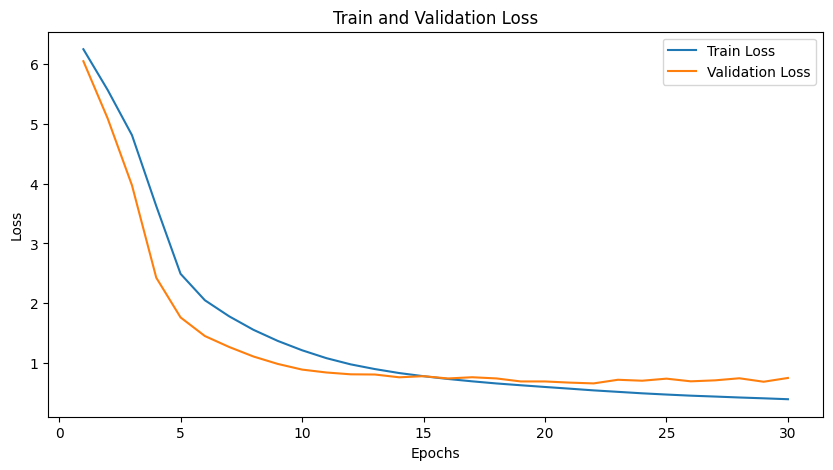

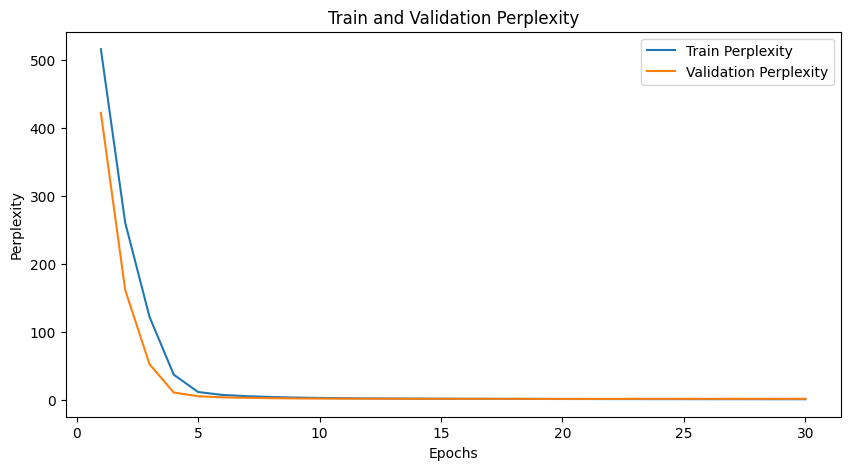

In [ ]:

import matplotlib.pyplot as plt
epochs = range(1, num_epochs+1)

# Plotting train loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting train perplexity
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexity, label='Train Perplexity')
plt.plot(epochs, val_perplexity, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Train and Validation Perplexity')
plt.legend()
plt.show()

In [ ]:
test_bleuscore = bleu_score(model, test_dataloader, device)
print(test_bleuscore)

<ipython-input-11-3b9c78d3e074>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = torch.tensor(src_batch).long().to(device)
<ipython-input-11-3b9c78d3e074>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt_batch = torch.tensor(tgt_batch).long().to(device)


0.5523539486520688


In [ ]:
def tokenize_prompt(prompt, src_tokenizer, device):
    tokens = src_tokenizer.encode(prompt)
    token_tensor = torch.tensor(tokens).long().unsqueeze(0).to(device)
    return token_tensor

In [ ]:
def tokens_to_text(tokens, tgt_tokenizer):
    return tgt_tokenizer.decode(tokens)

In [ ]:
def generate_text(model, prompt, device, max_length=100):
    src_input = bert_tokenizer.encode(prompt, add_special_tokens=True, max_length=max_length, truncation=True)
    src_input = torch.tensor(src_input).to(device).unsqueeze(0)
    desired_length = max_length

    generated_sequence = torch.zeros(1, max_length).long().to(device)  # Initialize generated sequence tensor

    for i in range(max_length):
        output, _, _ = model(src_input, generated_sequence)
        # print("output",output)
        # print("len_output",len(output))
        next_token = output[:, i].argmax(1)
        # print("next",bert_tokenizer.decode(next_token, skip_special_tokens=True))
        # print("next decoded",next_token)
        generated_sequence[:, i] = next_token

    generated_tokens = generated_sequence.squeeze(0).tolist()  # Remove batch dimension
    generated_text = bert_tokenizer.decode(generated_tokens, skip_special_tokens=True)
    

    return generated_text


In [ ]:
prompt = "There was a powerful leader in the Republic"
print("\nprompt: ", prompt)
generated_text = generate_text(model, prompt, device, 10)
print("generated_text: ", generated_text)




prompt:  There was a powerful leader in the Republic
generated_text:  covering problems issue when in power radical congregation crisis congregation


In [ ]:
prompt=' '.join(test_src_tokenized[22])
target=' '.join(test_tgt_tokenized[22])

print("\nprompt: ", prompt)
print("\ntarget: ", target)

generated_text = generate_text(model, prompt, device, 15)
print("generated_text: ", generated_text)


prompt:  wp you live in a world where light helps you retain and regain memory while darkness makes you forget everything one day

target:  jennifer woke up in a dark room no light she rubbed her eyes as if that would help her to see ` ` oh god what in the hell she threw herself on bed again too exhausted to move < newline > < newline > not that she remembers but waking up in the dark room with no memory happens to her on regular bases if she has a bad day she turns off the light before she goes to sleep so she does n't have to think about anything and possibly avoid nightmares < newline > < newline > but what the hell happened last night that made her this tired it must have been something horrible last time she was this tired to wake up was when her dog died she stayed in her dark room for 2 days straight < newline > < newline > ` ` i should get something to eat jennifer woke herself up and opened the door from the distance she saw a dim light from kitchen 's curtain a memory came b

# Conclusion

The model did not perform well. We have explained the reasons in the report in detail.